In [8]:
# This is code

# Import statements
import numpy as np
import pandas as pd
from BACKGROUND_PYTHON_SCRIPTS.FUNCTIONS.my_functions import *

%matplotlib widget
import sys
import os
from pathlib import Path

# Setting up the working directory
def find_project_dir(current_dir):
    for parent in current_dir.parents:
        if (parent / 'README.txt').exists():
            return parent
    return current_dir

current_directory = Path(os.getcwd())
project_dir = find_project_dir(current_directory)
os.chdir(project_dir)

# Creating working directories
notebooks_dir = project_dir / 'BACKGROUND_PYTHON_SCRIPTS'
data_dir = project_dir / 'input'
output_dir = project_dir / 'output'
data_selection = notebooks_dir / 'Data_Selection_Tool.ipynb'
functions_path = notebooks_dir / 'FUNCTIONS'
sys.path.append(str(functions_path))

# Importing the Background Notebooks
GNSS_data_import = notebooks_dir / 'GNSS_import.ipynb'
Data_trim_tool = notebooks_dir / 'Data_trim_tool.ipynb'

# Import visualisation
from IPython.display import HTML

<div style="background-color: lightblue; padding: 10px 0;">
    <h1 style="text-align: center; font-style: italic; margin: 0;">Data Processor for individual cross sections</h1>
</div>





Welcome to the GNSS python script that transforms the retrieved .pos files into cross-sectional river profiles. **The output files are:**
- A .csv file with cross-sectional information which can be imported into HEC-RAS
- Plots containing the cross-sectional information


In order for this notebook to function properly, please make sure the following **required packages** are installed in the currently running Conda Environment.

- Numpy
- Matplotlib
- ipywidgets

<div style="background-color: Lightblue; padding: 10px 0;">
    <h2 style="text-align: center; font-style: italic; margin: 0;">Importing GNSS Data</h2>
</div>

In the widget below, please provide:
- The file name (do not forget to add the .pos extention) of the file located in the GNSS_DATA_FOLDER
- The point name, which will be used as figure name

Then click the button "Import data". If all is right the dataframe is displayed. Otherwise the error message will indicate what is wrong.

In [2]:
%run "$GNSS_data_import"

Text(value='', description='Cross profile file name:', layout=Layout(width='600px'), placeholder='Enter the fi…

Text(value='', description='Waterlevel file name:', layout=Layout(width='600px'), placeholder='Enter the file …

Text(value='', description='Velocity profilefile name:', layout=Layout(width='600px'), placeholder='Enter the …

Text(value='', description='Point name:', layout=Layout(width='600px'), placeholder='Enter the point name', st…

Text(value='', description='Sticklength:', layout=Layout(width='600px'), placeholder='Enter the stick length i…

Button(description='Import data', style=ButtonStyle())

Output()

In [4]:
waterlevel = data_store['wl_data']['actual_height(m)'][-60:-1].mean()

<div style="background-color: Lightblue; padding: 10px 0;">
    <h2 style="text-align: center; font-style: italic; margin: 0;">Trim the dataset</h2>
</div>
Use the slider or the manual entry to delete the measurements that do not belong to the 

In [5]:
%run "$Data_trim_tool"

Button(description='Run this cell when data is loaded', layout=Layout(width='210px'), style=ButtonStyle())

Output()

Output()

In [6]:
measurements = data_store_cut['data_cut'].copy()
display(measurements)

,GPST,no.,latitude(deg),longitude(deg),height(m),Q,sticklength,actual_height(m)
2024/10/08,08:34:47.000,7,-1.025543,35.824123,1902.5408,2,1.51,1901.0308
2024/10/08,08:34:48.000,8,-1.025543,35.824123,1902.5101,2,1.51,1901.0001
2024/10/08,08:34:49.000,9,-1.025543,35.824123,1902.5270,2,1.51,1901.0170
2024/10/08,08:34:50.000,10,-1.025543,35.824123,1902.5168,2,1.51,1901.0068
2024/10/08,08:34:51.000,11,-1.025543,35.824123,1902.5468,2,1.51,1901.0368
...,...,...,...,...,...,...,...,...
2024/10/08,09:35:24.000,3637,-1.025810,35.824181,1902.3586,1,1.51,1900.8486
2024/10/08,09:35:25.000,3638,-1.025810,35.824181,1902.3633,1,1.51,1900.8533
2024/10/08,09:35:26.000,3639,-1.025810,35.824181,1902.3593,1,1.51,1900.8493
2024/10/08,09:35:27.000,3640,-1.025810,35.824181,1902.3545,1,1.51,1900.8445


<div style="background-color: Lightblue; padding: 10px 0;">
    <h2 style="text-align: center; font-style: italic; margin: 0;">Post-processing</h2>
</div>

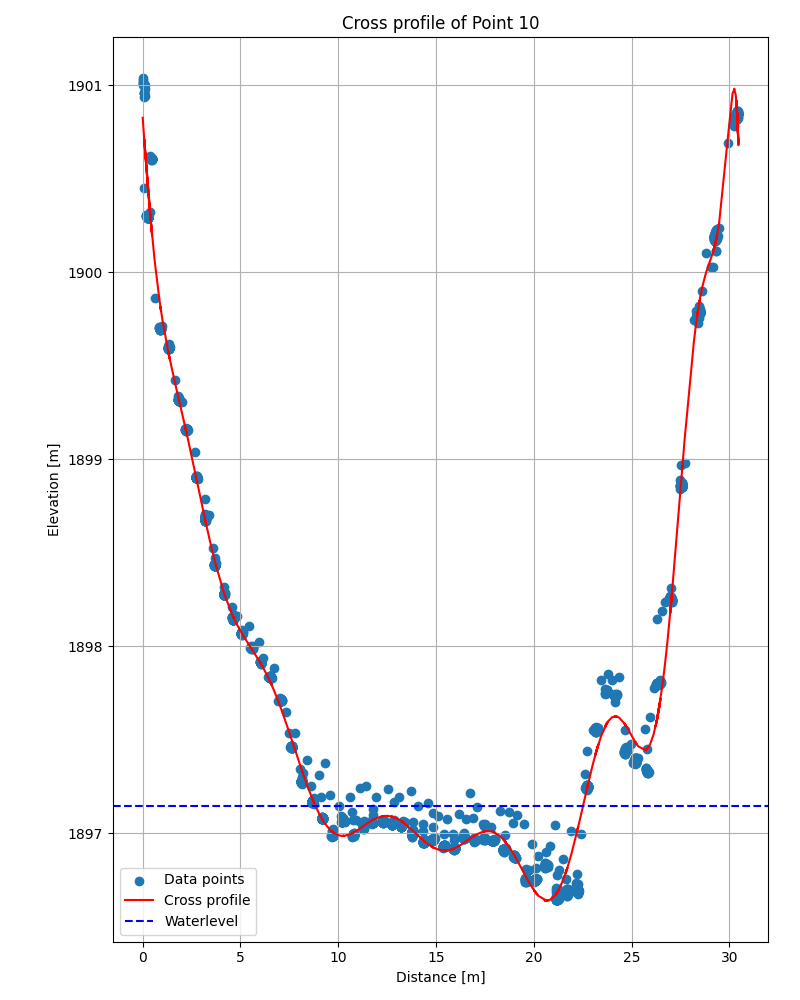

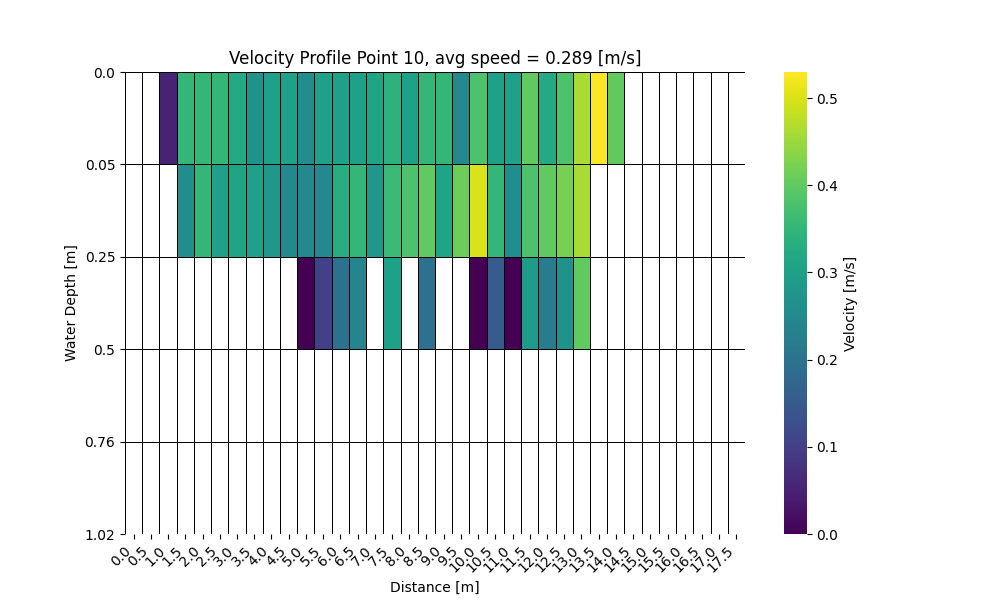

In [7]:
columns = ['pointname', 'mean_depth [m]', 'width [m]', 'area [m2]', 'hydraulic_depth [m]', 'hydraulic_radius [m]', 'avg_flow_velocity [m/s]', 'discharge [m3/s]']
hydraulic_parameters_df = pd.DataFrame(columns=columns)
point_name = data_store['point_name']

measurements['distance(m)'] = func_distance(
    measurements['latitude(deg)'],
    measurements['longitude(deg)']
)

fitted_values = func_fitline(measurements['distance(m)'], measurements['actual_height(m)'], waterlevel, point_name)

if waterlevel <= fitted_values.min():
    print('Error: Waterlevel is below the cross section. Please check if there is a mistake in the sticklength or measurements.')
else:
    hydraulic_parameters = func_hydraulic_parameters(waterlevel, fitted_values, measurements['distance(m)'])
    
    new_row = {
    'pointname': point_name, 
    'mean_depth [m]': hydraulic_parameters[0], 
    'width [m]': hydraulic_parameters[1],
    'area [m2]': hydraulic_parameters[2], 
    'hydraulic_depth [m]': hydraulic_parameters[3], 
    'hydraulic_radius [m]': hydraulic_parameters[4],
    'avg_flow_velocity [m/s]': '',
    'discharge [m3/s]': ''
    }
    
    hydraulic_parameters_df.loc[len(hydraulic_parameters_df)] = new_row

if pd.notna(data_store['vp_file_name']):
    avg_flow_velocity = func_velocityprofile(data_store['vp_file_name'], point_name)
    hydraulic_parameters_df.loc['avg_flow_velocity [m/s]'] = avg_flow_velocity
    hydraulic_parameters_df.loc['discharge [m3/s]'] = avg_flow_velocity * hydraulic_parameters[2]

export_x = measurements['distance(m)'][0::50]
export_y = fitted_values[0::50]
np.append(export_x, measurements['distance(m)'].values[-1])
np.append(export_y, fitted_values[-1])
export_data = {"x" : export_x,
           "y" : export_y}
export_dataframe = pd.DataFrame(export_data)
export_dataframe.to_csv(f'./output/{point_name}_out.csv', index=False)